In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# scipy imports
import scipy.stats as stats

# sklearn imports
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
# define cleaning functions
def clean_q_data_annual(dataframe):
    ''' 
    input: dataframe with re-named columns
    output: dataframe, series, series
    '''
    # datetime operations
    q_df['dt'] = pd.to_datetime(q_df['dt_string'])
    q_df['year'] = q_df['dt'].dt.year
    q_df['month'] = q_df['dt'].dt.month
    q_df['day'] = q_df['dt'].dt.day

    # new datetime without time
    q_df['timestamp'] = pd.to_datetime(q_df[['year','month', 'day']], errors='coerce')

    # make series from groupby, this has timestamp as index
    daily_q = q_df.groupby(['timestamp'])['cfs'].mean()

    # make df from series
    daily_q_df = pd.DataFrame(daily_q)
    
    # annual peak Q
    annual_peak_q = q_df.groupby(q_df.year)['cfs'].max()

#     # cumulative Q
#     sum_q = q_df.groupby(q_df.year)['cfs'].cumsum()
#     sum_q_df = pd.DataFrame(q_df.year,sum_q).reset_index()
#     annual_sum_q = sum_q_df.groupby(sum_q_df.year)['cfs'].max()

    return(daily_q_df, annual_peak_q)

def clean_snow_data_annual(dataframe):
    ''' 
    input: dataframe with re-named columns
    output: dataframe
    '''
    snow_df = dataframe
    # unit conversions to metric
    snow_df['swe_start_m'] = snow_df.swe_start_in * 0.0254
    snow_df['airtemp_max_C'] = 5/9*(snow_df.airtemp_max_F - 32)
    snow_df['airtemp_min_C'] = 5/9*(snow_df.airtemp_min_F - 32)
    snow_df['airtemp_mean_C'] = 5/9*(snow_df.airtemp_mean_F - 32)
    snow_df['precip_start_m'] = snow_df.precip_start_in * 0.0254
    snow_df['precip_incr_m'] = snow_df.precip_incr_in * 0.0254
    
    # drop standard unit columns
    snow_df.drop(['swe_start_in'], axis=1, inplace=True)
    snow_df.drop(['airtemp_max_F'], axis=1, inplace=True)
    snow_df.drop(['airtemp_min_F'], axis=1, inplace=True)
    snow_df.drop(['airtemp_mean_F'], axis=1, inplace=True)
    snow_df.drop(['precip_start_in'], axis=1, inplace=True)
    snow_df.drop(['precip_incr_in'], axis=1, inplace=True)
    
    # datetime operations
    snow_df['dt'] = pd.to_datetime(snow_df['dt_string'])
    snow_df['year'] = snow_df['dt'].dt.year

    # remove rows with swe=0
    snow_df.drop(snow_df[snow_df.swe_start_m == 0].index, inplace=True)

    #set snow df index to dt
    snow_df.set_index(snow_df.dt, inplace=True)
    
    # clean airtemp outlieres
    snow_df = remove_outliers(snow_df)
    
    # annual peak swe
    annual_peak_swe = snow_df.groupby(snow_df.year)['swe_start_m'].max()
    
    # annual cumulative swe
    cumsum_swe = snow_df.groupby(snow_df['year'])['swe_start_m'].cumsum()
    
    #cumsum_swe.reindex(snow_df.year)
    #cumsum_swe_df = pd.DataFrame(grp_year,cumsum_swe)
    #cumsum_swe_df.set_index(snow_df['year'])
    #annual_sum_swe = cumsum_swe_df.groupby(snow_df['year'])['swe_start_m'].max()
    
    return(snow_df, annual_peak_swe, cumsum_swe)

def remove_outliers(df):
    ''' 
    input: dataframe of snotel data with columns re-named for degrees C
    output: dataframe
    '''
    # clear min airtemp outliers
    df.drop(df[df.airtemp_min_C > 18].index, inplace=True)
    df.drop(df[df.airtemp_min_C < -40].index, inplace=True)
    # clear max airtemp outliers
    df.drop(df[df.airtemp_max_C > 50].index, inplace=True)
    df.drop(df[df.airtemp_max_C < -45].index, inplace=True)
    return(df)

In [3]:
# load q data
q_df = pd.read_csv('q-data/gunnison_delta.csv',sep='\t',header=32) # read csv to dataframe
q_df.columns = ['USGS', 'id', 'dt_string', 'tz', 'cfs', 'junk'] # rename columns

daily_q_df, annual_peak_q = clean_q_data_annual(q_df)

# annual sum q
annual_cumsum_q = daily_q_df.groupby(daily_q_df.index.year)['cfs'].cumsum()
annual_sum_q = annual_cumsum_q.groupby(annual_cumsum_q.index.year).max()

In [4]:
stationnames = ['737_schofield_pass','682_park_reservoir','669_north_lost_trail','618_mcclure_pass','622_mesa_lakes',
                '345_bison_lake','607_lynx_pass','542_independence_pass','793_stillwater_creek','842_vail_mountain']

cols_new = ['680_sumswe','762_sumswe','701_sumswe','737_sumswe','682_sumswe','669_sumswe','1059_sumswe',
            '618_sumswe','409_sumswe','675_sumswe',
            '680_peakswe','762_peakswe','701_peakswe','737_peakswe','682_peakswe','669_peakswe','1059_peakswe',
            '618_peakswe','409_peakswe','675_peakswe','peak_q','sum_q']


    

In [5]:
# load snotel data
stationnames = ['680_park_cone','762_slumgullion','701_porphyry_creek','737_schofield_pass',
                '682_park_reservoir','669_north_lost_trail','1059_cochetopa_pass','618_mcclure_pass',
                '409_columbine_pass','675_overland_reservoir']

stationnames_2 = ['737_schofield_pass','682_park_reservoir','669_north_lost_trail','618_mcclure_pass','622_mesa_lakes',
                '345_bison_lake','607_lynx_pass','542_independence_pass','793_stillwater_creek','842_vail_mountain']
# make data column names
cols_data = []
for station in stationnames:
    sum_list = '{}_sumswe'.format(station[:3])
    cols_data.append(sum_list)
    peak_list = '{}_peakswe'.format(station[:3])
    cols_data.append(peak_list)
cols_data.append('peak_q')
cols_data.append('sum_q')
#    cols_data.append(sum_list + peak_list) # this sums them together
#     cols_data += sum_list #this does not make a list
#     cols_data += peak_list# ha this adds them elementwise

# merge snotel data with q data
data_lst = []
count = 0
peakswe_lst = []
sumswe_lst = []
for stationname in stationnames:
    snow_df = pd.read_csv('snotel-data/snotel_{}.csv'.format(stationname),header=58) 
    snow_df.columns = ['dt_string', 'swe_start_in',
       'precip_start_in',
       'airtemp_max_F', 'airtemp_min_F',
       'airtemp_mean_F', 'precip_incr_in']
    
    # import cleaned snow data
    snow_df, annual_peak_swe, cumsum_swe = clean_snow_data_annual(snow_df)

    # merge datasets
    merged_df = pd.merge(snow_df, daily_q_df, how='left', left_index=True, right_index=True)

    data_lst.append(merged_df)
    peakswe_lst.append(annual_peak_swe)
    sumswe_lst.append(cumsum_swe)
    count += 1
print(count)
# peak swe for each station
data_df = pd.concat(data_lst, axis=0, ignore_index = True)
peakswe_df = pd.concat(peakswe_lst,axis=1)
peakswe_df.columns = stationnames
# cumsum swe for each station
cumsum_swe_df = pd.concat(sumswe_lst,axis=1)
cumsum_swe_df.columns = stationnames
# max sum swe by year for each station
cumsum_swe_df['year'] = cumsum_swe_df.index.year
sum_list = []
for name in stationnames:
    sum_list.append(cumsum_swe_df.groupby(cumsum_swe_df.year)[name].max())
sumswe_df = pd.concat(sum_list,axis=1)
sumswe_df.columns = stationnames

10


In [6]:
# eda of outliers removed
data_df.describe()

,swe_start_m,airtemp_max_C,airtemp_min_C,airtemp_mean_C,precip_start_m,precip_incr_m,year,cfs
count,76648.000000,68777.000000,69006.000000,69193.000000,76841.000000,76806.000000,76907.000000,63394.000000
mean,0.295663,3.473561,-9.407612,-3.669695,0.381339,0.002952,1999.778291,1764.800678
std,0.243740,7.036426,6.871947,6.361335,0.269997,0.005650,10.468496,1712.658188
min,0.002540,-32.222222,-40.000000,-33.888889,0.000000,0.000000,1978.000000,294.708333
25%,0.109220,-1.666667,-13.888889,-7.777778,0.167640,0.000000,1991.000000,827.750000
50%,0.238760,3.333333,-8.888889,-3.333333,0.320040,0.000000,2000.000000,1158.333333
75%,0.419100,8.333333,-4.444444,0.555556,0.541020,0.002540,2009.000000,1977.812500
max,1.554480,44.444444,11.111111,22.777778,1.772920,0.101600,2018.000000,15335.416667


In [7]:
# merge q and swe data
data_x = pd.merge(sumswe_df,peakswe_df, how='left', left_index=True, right_index=True)
data_xy = pd.concat((data_x,annual_peak_q,annual_sum_q),axis=1)

# new columns
# cols_new = ['680_sumswe','762_sumswe','701_sumswe','737_sumswe','682_sumswe','669_sumswe','1059_sumswe',
#             '618_sumswe','409_sumswe','675_sumswe',
#             '680_peakswe','762_peakswe','701_peakswe','737_peakswe','682_peakswe','669_peakswe','1059_peakswe',
#             '618_peakswe','409_peakswe','675_peakswe','peak_q','sum_q']
data_xy.columns = cols_data

# clean data matrix
data_xy.drop(data_xy[data_xy.index < 1985].index, inplace=True)

# impute nans instead of remove
data_xy_impute = data_xy.fillna(0) # only missing values for 1059

# drop nans
# data_xy_clean = data_xy.dropna()


In [8]:
data_xy.tail(20)

,737_sumswe,737_peakswe,682_sumswe,682_peakswe,669_sumswe,669_peakswe,618_sumswe,618_peakswe,622_sumswe,622_peakswe,...,607_sumswe,607_peakswe,542_sumswe,542_peakswe,793_sumswe,793_peakswe,842_sumswe,842_peakswe,peak_q,sum_q
1999,92.70238,83.37042,31.96844,33.17748,40.53332,84.83346,25.97404,49.40808,14.26210,44.38904,...,0.32766,0.32766,0.47752,0.73406,0.24384,0.52324,0.17780,0.44958,5560.0,600313.509426
2000,78.21168,58.97372,36.97732,37.31006,33.23844,70.10654,27.33802,39.70020,23.11146,59.54014,...,0.42926,0.42926,0.39116,0.59690,0.28448,0.37338,0.26924,0.57658,4190.0,443597.946265
2001,95.79610,61.63056,30.82798,38.61816,36.26358,78.09484,25.72512,41.97096,16.46428,53.56860,...,0.30734,0.37592,0.42418,0.65786,0.27686,0.38354,0.18034,0.50292,4070.0,348092.019928
2002,78.76540,49.04486,23.88362,30.47238,24.87422,56.58866,20.26158,35.02914,13.13942,49.39284,...,0.30480,0.30480,0.24384,0.42164,0.23114,0.32766,0.15240,0.37084,1590.0,222345.018241
2003,97.07880,77.98308,38.52164,44.04614,49.67986,87.39632,30.76194,50.59172,26.64968,70.06590,...,0.36322,0.42672,0.46736,0.70358,0.28194,0.44450,0.29972,0.71120,4920.0,306414.969046
2004,97.40646,101.44252,41.96588,37.44722,62.00648,94.29242,19.46148,42.86250,14.58214,47.49800,...,0.40132,0.37592,0.50546,0.66040,0.21844,0.36068,0.17018,0.42672,2650.0,303399.118164
2005,153.17216,172.52188,69.25564,70.19544,89.84742,124.78766,29.00172,53.20030,21.30552,64.96050,...,0.61468,0.66294,0.76708,0.82042,0.27686,0.41402,0.20066,0.50800,8880.0,635346.889409
2006,110.43666,74.87158,45.30344,49.41570,46.52518,105.65638,37.29482,52.31384,25.20696,88.76792,...,0.44196,0.52070,0.45466,0.83566,0.36068,0.43180,0.26924,0.74168,5770.0,578929.580416
2007,83.61172,58.67654,38.62070,39.18458,37.83076,73.35774,28.75788,50.03546,18.33372,53.72862,...,0.39116,0.39370,0.33020,0.58420,0.28194,0.41402,0.23876,0.48514,3410.0,515096.659339
2008,181.44744,125.24994,84.47532,75.97140,67.17538,130.27406,44.47032,80.88122,27.08402,90.29192,...,0.78232,0.74422,0.59182,0.87376,0.43180,0.68072,0.27432,0.74676,13300.0,954193.001150


In [9]:
data_xy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34 entries, 1985 to 2018
Data columns (total 22 columns):
737_sumswe     34 non-null float64
737_peakswe    34 non-null float64
682_sumswe     34 non-null float64
682_peakswe    34 non-null float64
669_sumswe     33 non-null float64
669_peakswe    34 non-null float64
618_sumswe     34 non-null float64
618_peakswe    34 non-null float64
622_sumswe     34 non-null float64
622_peakswe    34 non-null float64
345_sumswe     34 non-null float64
345_peakswe    34 non-null float64
607_sumswe     34 non-null float64
607_peakswe    34 non-null float64
542_sumswe     33 non-null float64
542_peakswe    34 non-null float64
793_sumswe     34 non-null float64
793_peakswe    34 non-null float64
842_sumswe     34 non-null float64
842_peakswe    34 non-null float64
peak_q         34 non-null float64
sum_q          34 non-null float64
dtypes: float64(22)
memory usage: 6.1 KB


In [10]:
# prep data for model
model_df = data_xy_impute
cols = model_df.columns

# split train and test data
split_year = 2010

train_df = data_xy_impute[data_xy_impute.index < split_year]
test_df = data_xy_impute[data_xy_impute.index >= split_year]

X_train = train_df[cols[:-2]]
y_train = train_df[cols[-1]] # -2 is peak q, -1 is sum q

X_test = test_df[cols[:-2]]
y_test = test_df[cols[-1]] # -2 is peak q, -1 is sum q



In [11]:
# make and fit model
alpha= 5000
model = Ridge(alpha)
model.fit(X_train, y_train);
y_hat_train = model.predict(X_train)
y_hat_test = model.predict(X_test)
# R2 score
score = model.score(X_test,y_test)
print('R2 = {0:.3f}'.format(score))

coefs = model.coef_
print(coefs)


R2 = 0.575
[ 3.90365981e+03  5.14770775e+02  1.31579823e+03  1.75229997e+03
  1.27450441e+03 -1.77726929e+02  2.13075035e+02  2.08962075e+03
  3.10284223e+02  5.45179456e+02  4.39193977e+01  2.38768985e+01
  1.16795332e+01  1.81453498e+01  2.11934816e+01  7.42598207e+00
 -3.40600716e+00  2.81921215e+01  6.88949998e-01  8.55020074e+00]


In [12]:
# coefficient matrix
# D = {}
# for idx, name in enumerate(stationnames):
#     D[name] = [[x for x in coefs[idx]], [y for y in coefs[idx+7]]]
# #print(D)

# import csv
# #write to file:
# with open('gunnison_coefs_peak_q.csv', 'w') as csv_file:
#     writer = csv.writer(csv_file)
#     for k, v in D.items():
#        writer.writerow([k,v])

sumswe_df.head()

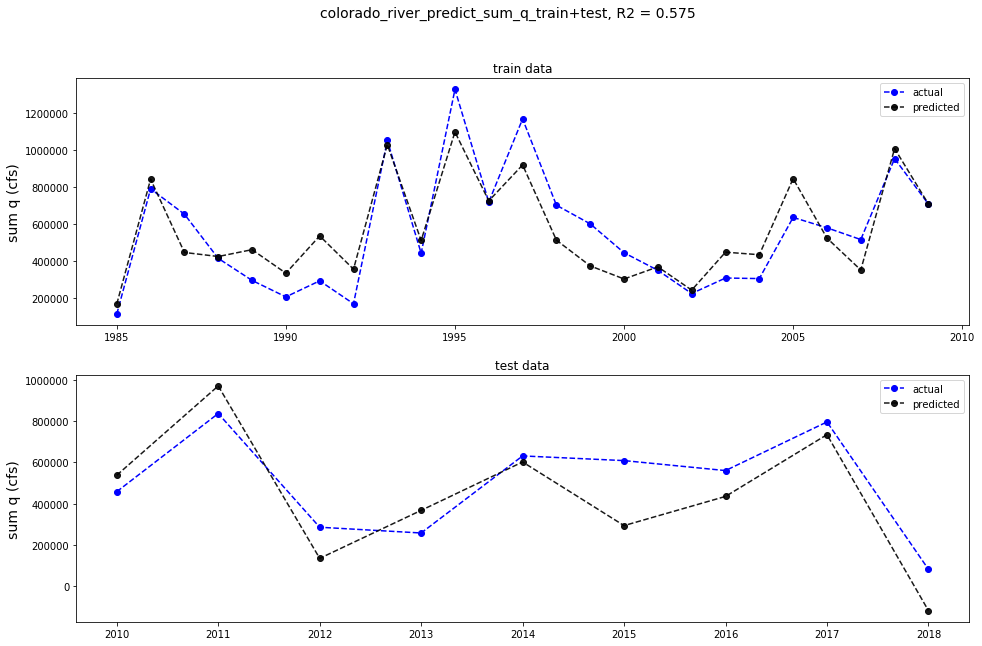

In [15]:
# plot predictions
# plots swe A, B
df = model_df # dataframe to plot from
#y # already made
#y_hat # already made
figname = 'colorado_river_predict_sum_q_train+test'

# plot
fig, ax = plt.subplots(2,1,figsize=(16,8));
ax[0].plot(y_train.index,y_train,'bo--')
ax[0].set_ylabel('sum q (cfs)', fontsize=14);
#ax[0].set_xlabel('year', fontsize=14)
ax[0].plot(y_train.index,y_hat_train,'ko--',alpha=0.9)
ax[0].legend(['actual','predicted'])
ax[0].set_title('train data')

ax[1].plot(y_test.index,y_test,'bo--')
ax[1].set_ylabel('sum q (cfs)', fontsize=14);
#ax[1].set_xlabel('year', fontsize=14)
ax[1].plot(y_test.index,y_hat_test,'ko--',alpha=0.9)
ax[1].legend(['actual','predicted'])
ax[1].set_title('test data')
plt.suptitle('{}, R2 = {}'.format(figname,str(round(score,3))),fontsize=14)

# arrs = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]
# for x, col in enumerate(cols[:-1]):
#     ax[arrs[x]].plot(df[col].values,y,'bo')
#     ax[arrs[x]].set_ylabel('q (cfs)');
#     ax[arrs[x]].set_xlabel(cols[x])
#     ax[arrs[x]].plot(df[col].values,y_hat,'ko')
#     ax[arrs[x]].legend(['actual','predicted'])
# plt.suptitle('{}, R2 = {}'.format(figname,str(round(score,3))),fontsize=14)

# save fig
fig.set_size_inches(16, 10)
plt.savefig('{}.png'.format(figname),format='png', dpi=300)

In [14]:
# # explore X,y
# fig, ax = plt.subplots(1,4,figsize=(16,8));
# ax[0].plot(X[cols[0]],y,'bo')
# #ax[0].set_ylabel('q (cfs)');
# #ax.set_xlabel(cols[x])
# ax[1].plot(X[cols[1]],y,'ko',alpha=0.1)
# #ax.legend(['actual','predicted'])